In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths,\
confusion_matrix



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/2MX/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)


CPU times: user 392 µs, sys: 0 ns, total: 392 µs
Wall time: 669 µs


In [10]:
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.325735]
r_big = [0.325735,0.46065886]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000


In [11]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722
2,0.423655,0.645894,2,0,5.106052,2.580146,-2.525906
3,0.437587,0.891773,1,1,-2.702391,-0.191128,-2.511263
4,0.963663,0.383442,0,0,4.275959,1.875316,-2.400644


In [12]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.000020e+00,5.001005e-01,8.336311e-01,8.356772e-01,1.001270e+00
std,2.887267e-01,2.886267e-01,8.164207e-01,5.000001e-01,2.114240e+00,2.114881e+00,2.942197e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-9.038117e+00,-9.171530e+00,-1.255560e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-5.943142e-01,-5.947750e-01,-9.836229e-01
50%,4.999703e-01,5.003810e-01,1.000000e+00,1.000000e+00,8.322795e-01,8.316667e-01,9.981741e-01
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,2.258773e+00,2.263374e+00,2.988030e+00
max,9.999993e-01,9.999997e-01,2.000000e+00,1.000000e+00,1.164953e+01,1.161717e+01,1.488689e+01


In [13]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


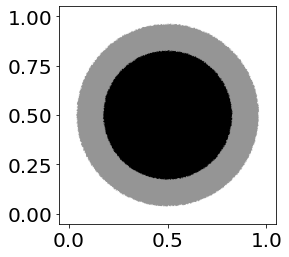

In [14]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [15]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Train X learner to directly calculate effect
#### Use gradient boosting trees for estimation models and  loistic Regression for Rest

In [16]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

m0 = GDBR(**f1_kwargs)
m1 = GDBR(**f1_kwargs)
t0 = GDBR(**f1_kwargs)
t1 = GDBR(**f1_kwargs)

model = XL((m0,m1), (t0,t1), categories=[0,1])
xml = model.fit(data.Y, data.Treatment, X = data[['x0','x1']])

CPU times: user 3h 59min 53s, sys: 16.2 s, total: 4h 9s
Wall time: 4h 1min 32s


### Get Xlearner Effects and add it as a column to the data

In [17]:
data['ITE-XML'] = xml.effect(data[['x0','x1']])
print(data['ITE-XML'].min(), data['ITE-XML'].max())

-5.477284810929481 4.881247016043902


### Xlearner Effect histogram 

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


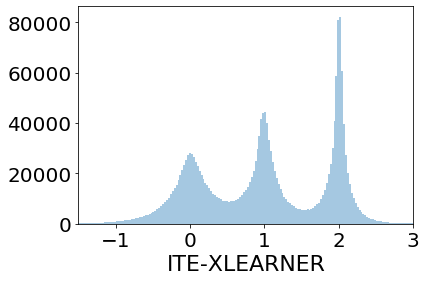

In [18]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)


fig, ax = plt.subplots()

bins = 400
ax = sns.distplot(data['ITE-XML'],  bins=bins, kde = False,ax = ax)
ax.set_xlabel('ITE-XLEARNER')
ax.set_xlim(-1.5,3)
if save:
    fig.savefig(path2+'xlearnhist.pdf', bbox_inches='tight',pad_inches = 0)

### 3Clustering of Xlearner effects

In [19]:
cluster_name = 'ITE-XML-3Clust'
col = 'ITE-XML'
filt1 = data[col] <= 0.5
filt2 = data[col] >= 0.5
filt3 = data[col] >= 1.5

data[cluster_name] = 0
data.loc[filt1,cluster_name] = 0
data.loc[filt2, cluster_name] = 1
data.loc[filt3, cluster_name] = 2


#data,_ = kmeans_clustering(data, clusters = 3, cluster_name = 'ITE-XML-3Clust',col_select = ['ITE-XML'] )

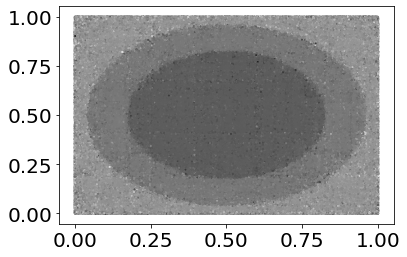

In [20]:
fig, ax = plt.subplots()
data3 = data.copy()
data3['ITE-XML']  = np.minimum(7,np.maximum(-5, data.copy()['ITE-XML']))

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data3['ITE-XML'], cmap = 'Greys', s = 1)

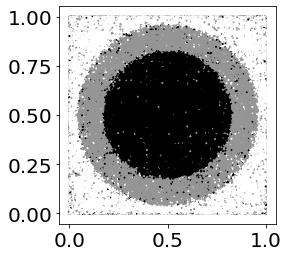

In [21]:
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)

fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-XML-3Clust'], cmap = 'Greys', s = 1)
if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format('ITE-XML-3Clust'), bbox_inches='tight',pad_inches = 0)

### Xlearner 6Clustering mean absolute error versu eligibility

In [22]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group

In [23]:
ite_column = 'ITE-XML'
clust2 = 'ITE-XML-3Clust'
data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [24]:
errors = data.describe().loc[['mean', 'std'], [col for col in data.columns if 'err' in col]].T

In [25]:
errors

,mean,std
ITE-XML-3Clust-err-GDBR,0.101215,0.272262


In [26]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)

mat = confusion_matrix(data, 'C', 'ITE-XML-3Clust', 3, save = save, save_dir = path4)
display(mat)

,C0 Pred,C1 Pred,C2 Pred
C0 True,0.899766,0.094502,0.005731
C1 True,0.053947,0.895720,0.050333
C2 True,0.000389,0.024359,0.975252


In [27]:
data.groupby('ITE-XML-3Clust').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,ITE-XML,ITE-XML-3Clust-err-GDBR
ITE-XML-3Clust,,,,,,,,,
0,0.500134,0.499088,0.057388,0.498940,0.971653,0.974419,-0.277048,-0.051629,0.109017
1,0.499087,0.500917,0.930902,0.500309,0.556368,0.560484,1.072851,0.984803,0.129461
2,0.500145,0.500519,1.940057,0.500969,0.978832,0.978176,2.113371,1.992983,0.066197


In [28]:
np.mean(np.abs(data['C'] - data['ITE-XML'])), np.std(np.abs(data['C'] - data['ITE-XML']))

(0.21261672341026183, 0.26017500672091715)